In [1]:
# Copyright 2024 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<span style="font-size:2em;">A Richer Knowledge Base for LLMs using mRAG</span> 


<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/Fady-Ibra/RAG/blob/master/mRAG.ipynb">
      <img width="32px" src="https://www.gstatic.com/pantheon/images/bigquery/welcome_page/colab-logo.svg" alt="Google Colaboratory logo"><br> Run in Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https:%2F%2Fraw.githubusercontent.com%2FFady-Ibra%2FRAG%2Fblob%2Fmasterm%2FRAG.ipynb">
      <img width="32px" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" alt="Google Cloud Colab Enterprise logo"><br> Run in Colab Enterprise
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://github.com/Fady-Ibra/RAG/mRAG.ipynb.ipynb">
      <img width="32px" src="https://upload.wikimedia.org/wikipedia/commons/9/91/Octicons-mark-github.svg" alt="GitHub logo"><br> View on GitHub
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/Fady-Ibra/RAG/blob/master/mRAG.ipynb">
      <img src="https://www.gstatic.com/images/branding/gcpiconscolors/vertexai/v1/32px.svg" alt="Vertex AI logo"><br> Open in Vertex AI Workbench
    </a>
  </td>    
</table>


- Authors: [Lavi Nigam](https://github.com/lavinigam-gcp) & [Fady Ibrahim](https://github.com/Fady-Ibra)
- Forked from: [Google Cloud Gen AI Repo](https://github.com/GoogleCloudPlatform/generative-ai/blob/main/gemini/qa-ops/building_DIY_multimodal_qa_system_with_mRAG.ipynb)

# What We will Do

## Overview
- We'll create a QA sys that understands both text and images
- We'll build this system using Vertex AI

* **Focus on Fundamentals**: We will start with the essential design pattern of "Retrieval Augmented Generation" (RAG) – a way to find and use relevant info to answer questions.
* **Work with Text and Images**: We will expand RAG to handle both text and images found in PDF documents.
* **Use Vertex AI**: We will use Vertex AI Embeddings API and Vertex AI Gemini API.

By the end of this guide, we will have a solid foundation in building multimodal QA systems.

## Gemini
- Gemini is a family of GenAI models that is designed for multimodal use cases. 
- The Vertex AI Gemini API gives us access to:
    - Gemini 1.0 Pro Model
    - Gemini 1.0 Pro Vision Model
    - Gemini 1.5 Pro Model
    - Gemini 1.5 Flash Model

## Comparing text-based and mRAG
Multimodal RAG (mRAG) offers several advantages over text-based RAG:
1. **Enhanced knowledge access:** mRAG can access and process both textual and visual info, providing a richer and more comprehensive knowledge base for the LLM.
2. **Improved reasoning capabilities:** By incorporating visual cues, mRAG can make better informed inferences across different types of data modalities.

## How to implement RAG 
We will implement RAG using:
- Vertex AI Gemini API
- Vertex AI Embeddings API
  - [text embeddings](https://cloud.google.com/vertex-ai/docs/generative-ai/model-reference/text-embeddings)
  - [multimodal embeddings](https://cloud.google.com/vertex-ai/docs/generative-ai/model-reference/multimodal-embeddings), to build a doc search engine.

## Objectives
This notebook provides a guide to building a doc search engine using mRAG, step by step:
1. Extract and store metadata of docs containing both text and images, and generate embeddings the docs
2. Search the metadata with text queries to find similar text or images
3. Search the metadata with image queries to find similar images
4. Using a text query as input, search for contextual answers using both text and images

## Costs
- [Vertex AI pricing](https://cloud.google.com/vertex-ai/pricing)
- [Pricing Calculator](https://cloud.google.com/products/calculator) (generates a cost estimate)


# Getting Started
## Install Vertex AI SDK and other dependencies
**Next Command Explanation**
- **!** to execute a command
- **pip3** a Python Package Manager (with a recursive acronym PIP Installs Packages)
- **--upgrade (-U)** INSTALL OPTIONS upgrade all packages to the newest available version
- **--user** install packages in the user home directory (pip defaults to installing Python packages to a sys directory, as /usr/local/lib/python3.4, which requires root access)

In [1]:
!pip3 install --upgrade --user google-cloud-aiplatform | grep -v "already satisfied"
!pip3 install --upgrade --user pymupdf                 | grep -v "already satisfied"
!pip3 install --upgrade --user rich                    | grep -v "already satisfied"

### Restart the kernel
- To use the newly installed packages, we must restart the kernel. 
- Restarting the kernel after installs so that our environment can access the new packages
- To know more about the kernel, please check the image below ([image source](https://ipython.org/ipython-doc/3/development/how_ipython_works.html)).
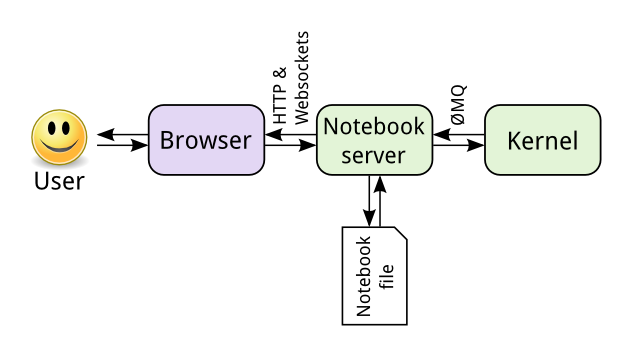

## Authenticate your notebook environment (Colab only)

If you are running this notebook on Google Colab, run the following cell to authenticate your environment. This step is not required if you are using [Vertex AI Workbench](https://cloud.google.com/vertex-ai-workbench).


In [1]:
import sys
    
if "google.colab" in sys.modules:
    print("I am in Colab")
    from google.colab import auth
    auth.authenticate_user() # Authenticate user to Google Cloud

## Define Google Cloud project information


In [2]:
import sys

PROJECT_ID = ""  
LOCATION = "us-central1" 

# if not running on Colab, try to get the PROJECT_ID automatically
if "google.colab" not in sys.modules:
    CMD_OUTPUT = !gcloud config get-value project
    PROJECT_ID = CMD_OUTPUT[0]

print(f"Cmd Output: {CMD_OUTPUT}")
print(f"Project ID: {PROJECT_ID}")

Cmd Output: ['ai-gcp-demos']
Project ID: ai-gcp-demos


In [3]:
import vertexai

vertexai.init(project=PROJECT_ID, location=LOCATION)

## Load Gemini models

In [8]:
from vertexai.generative_models import GenerativeModel
from vertexai.language_models import TextEmbeddingModel
from vertexai.vision_models import MultiModalEmbeddingModel

# Text model: works with: 
#   1) text, code
model_10p   = GenerativeModel("gemini-1.0-pro") 

# Multimodal models: works with 
#   1) text, code, 
#   2) video(without audio), and 
#   3) images 
# with 16k input context
model_10pv  = GenerativeModel("gemini-1.0-pro-vision-001") 

# Multimodal models: works with 
#   1) text, code, 
#   2) images, 
#   3) video(with or without audio) and 
#   4) audio(mp3) 
# with 2M or 1M input context 
# Choose based on performance/cost needs
model_15p = GenerativeModel("gemini-1.5-pro-001")   
model_15f = GenerativeModel("gemini-1.5-flash-001") 

# Load text embedding model from pre-trained source
model_tEMB = TextEmbeddingModel.from_pretrained("text-embedding-004")

# Load multimodal embedding model from pre-trained source
# works with 
#   1) image, 
#   2) image with caption(~32 words), 
#   3) video, 
#   4) video with caption(~32 words)
model_mEMB = MultiModalEmbeddingModel.from_pretrained("multimodalembedding")

## Get documents and images from GCS
**gcloud storage rsync**
makes the contents under the destination the same as the contents under the source, by
- copying any missing files/objects (or those whose data has changed), and 
- (if the -d option is specified) deleting any extra files/objects

**Options of the command:**
- **--quiet (-q)** Top-level option for the gcloud CLI that disables all interactive prompts when running gcloud CLI commands and is useful for scripting. 
- **-r** to copy an entire directory tree

In [14]:
# download documents and images used in this notebook
!gcloud -q storage rsync -r gs://github-repo/rag/intro_multimodal_rag/intro_multimodal_rag_v2 .
#!rm -f data/Google\ Cloud\ TPU\ blog.pdf
!rm -f data/med_gemini.pdf

At file://./**, worker process 40142 thread 140640584292160 listed 40...
At gs://github-repo/rag/intro_multimodal_rag/intro_multimodal_rag_v2/**, worker process 40142 thread 140640584292160 listed 90...
Copying gs://github-repo/rag/intro_multimodal_rag/intro_multimodal_rag_v2/data/Google Cloud TPU blog.pdf to file://./data/Google Cloud TPU blog.pdf
Copying gs://github-repo/rag/intro_multimodal_rag/intro_multimodal_rag_v2/images/Google Cloud TPU blog.pdf_image_11_0_62.jpeg to file://./images/Google Cloud TPU blog.pdf_image_11_0_62.jpeg
Copying gs://github-repo/rag/intro_multimodal_rag/intro_multimodal_rag_v2/images/Google Cloud TPU blog.pdf_image_11_1_63.jpeg to file://./images/Google Cloud TPU blog.pdf_image_11_1_63.jpeg
Copying gs://github-repo/rag/intro_multimodal_rag/intro_multimodal_rag_v2/images/Google Cloud TPU blog.pdf_image_12_0_66.jpeg to file://./images/Google Cloud TPU blog.pdf_image_12_0_66.jpeg
Copying gs://github-repo/rag/intro_multimodal_rag/intro_multimodal_rag_v2/image

# Building metadata of documents containing text and images

## The data
The source data that we will use in this notebook are:

* [Google Cloud TPU Scaling blog](https://storage.googleapis.com/github-repo/rag/intro_multimodal_rag/data/Google%20Cloud%20TPU%20blog.pdf)
* [Gemini 1.5 Technical Report](https://storage.googleapis.com/github-repo/rag/intro_multimodal_rag/data/gemini_v1_5_report_technical.pdf)
* [Google Gemma Technical Paper](https://storage.googleapis.com/github-repo/rag/intro_multimodal_rag/data/gemma_technical_paper.pdf)
* [Med-Gemini Technical Paper](https://storage.googleapis.com/github-repo/rag/intro_multimodal_rag/data/med_gemini.pdf)

We can also use other data, by deleting the current files and then placing new files in the `data` folder

## Extract and store metadata of text and images from a document
- The function `get_document_metadata()` extracts text and image metadata from a document, and returns two dataframes, namely *text_metadata* and *image_metadata*. 
- To know more about how `get_document_metadata()` is implemented using Gemini and the embedding models, please check the [source code](https://github.com/GoogleCloudPlatform/generative-ai/blob/main/gemini/use-cases/retrieval-augmented-generation/utils/intro_multimodal_rag_utils.py).

- At the next step, we will use the function to extract and store metadata of text and images from a document. 
- NOTE: We are loading 4 files with roughly 200 pages and approximately 84 images, the cell below  may take a few minutes to complete. We recommend loading pre-computed metadata instead.


In [11]:
import time
from vertexai.generative_models import GenerationConfig, HarmCategory, HarmBlockThreshold
from multimodal_qa_with_rag_utils import get_document_metadata
from multimodal_qa_with_rag_utils import set_global_variable

set_global_variable("text_embedding_model", model_tEMB)
set_global_variable("multimodal_embedding_model", model_mEMB) 

In [15]:
%%time          
                # Cell Magic Command %%time to output the execution time of the entire cell
!rm -rf images/ # Remove pre-exsisting images folder (here we are running the logic from scratch)

image_description_prompt = """
- You are a technical image analysis expert. 
- You will be provided with various types of images extracted from docs.
- This docs include research papers, technical blogs, and more.
- Your task is to generate concise, accurate descriptions of the images.
- Please do not add any info you are not confident about.
- Focus on capturing the key details, trends, or relationships depicted in the images.

Important Guidelines:
* Prioritize accuracy:  If you are uncertain about any detail, state "Not visible" instead of guessing.
* Avoid hallucinations: Do not add info that is not directly supported by the image.
* Be specific:          Use precise language to describe shapes, colors, textures, and any interactions depicted.
* Consider context:     If the image is a screenshot or contains text, incorporate that info into description.
"""

safety_settings = {
    HarmCategory.HARM_CATEGORY_HARASSMENT:        HarmBlockThreshold.BLOCK_ONLY_HIGH,
    HarmCategory.HARM_CATEGORY_HATE_SPEECH:       HarmBlockThreshold.BLOCK_ONLY_HIGH,
    HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT: HarmBlockThreshold.BLOCK_ONLY_HIGH,
    HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: HarmBlockThreshold.BLOCK_ONLY_HIGH,
}

# Extract text and image metadata from the PDF docs
text_metadata_df, image_metadata_df = get_document_metadata(
    model_15p,  
    pdf_folder_path           = "data",
    image_save_dir            = "images",
    embedding_size            = 1408,  # dimension must be one of 128, 256, 512, 1408.
    add_sleep_after_page      = True, 
    sleep_time_after_page     = 12,    # in seconds, increase value if getting quota issues
    add_sleep_after_document  = True, 
    sleep_time_after_document = 30,    # in seconds, increase value if getting quota issues
    image_description_prompt  = image_description_prompt,
    safety_settings           = safety_settings,        
    generation_config         = GenerationConfig(temperature=0.2, max_output_tokens=2048) #fady
)



 Processing the file: --------------------------------- data/gemini_v1_5_report_technical.pdf 


Processing page: 1
Extracting image from page: 1, saved as: images/gemini_v1_5_report_technical.pdf_image_0_0_1910.jpeg
Sleeping for  12  sec before processing the next page to avoid quota issues. You can disable it: "add_sleep_after_page = False"  
Processing page: 2
Sleeping for  12  sec before processing the next page to avoid quota issues. You can disable it: "add_sleep_after_page = False"  
Processing page: 3
Sleeping for  12  sec before processing the next page to avoid quota issues. You can disable it: "add_sleep_after_page = False"  
Processing page: 4
Sleeping for  12  sec before processing the next page to avoid quota issues. You can disable it: "add_sleep_after_page = False"  
Processing page: 5
Extracting image from page: 5, saved as: images/gemini_v1_5_report_technical.pdf_image_4_0_142.jpeg
Extracting image from page: 5, saved as: images/gemini_v1_5_report_technical.pdf_imag

We can check additional Gemini API parameters and safety setting while building metadata:
- [Gemini API parameters](https://cloud.google.com/vertex-ai/docs/generative-ai/model-reference/gemini)
- [Safety settings and thresholds](https://cloud.google.com/vertex-ai/docs/generative-ai/multimodal/configure-safety-attributes)
- We can also pass parameters and safety setting to `get_gemini_response` function

## Load pre-computed metadata of text and images from source document
**If you are facing issues with Quota or want to focus on the outputs, we can load pre-computed metadata.**

In [12]:
#To use this cell, uncomment by removing """ at the start and """ at the end
"""
import pickle

# Load the pickle file
with open("mrag_metadata.pkl", "rb") as f:
    data = pickle.load(f)

# Extract the DataFrames
print(type(data))
text_metadata_df = data["text_metadata"]
image_metadata_df = data["image_metadata"]
"""

'\nimport pickle\n\n# Load the pickle file\nwith open("mrag_metadata.pkl", "rb") as f:\n    data = pickle.load(f)\n\n# Extract the DataFrames\nprint(type(data))\ntext_metadata_df = data["text_metadata"]\nimage_metadata_df = data["image_metadata"]\n'

### Inspect the processed text metadata


The following cell will produce a metadata table which describes the different parts of text metadata, including:

- **text**: the page text
- **text_embedding_page**: the embedding of the page text
- **chunk_text**: the page text divided into smaller chunks
- **chunk_number**: the index of each text chunk
- **text_embedding_chunk**: the embedding of each text chunk

In [16]:
print(text_metadata_df.shape)
print("*****************************************************************************")
print(text_metadata_df.iloc[0, :]);
print("*****************************************************************************")
print(text_metadata_df.iloc[1, :]);
print("*****************************************************************************")

(310, 7)
*****************************************************************************
file_name                                gemini_v1_5_report_technical.pdf
page_num                                                                1
text                    Gemini 1.5: Unlocking multimodal\nunderstandin...
text_embedding_page     [0.01204244140535593, 0.01964735984802246, -0....
chunk_number                                                            1
chunk_text              Gemini 1.5: Unlocking multimodal\nunderstandin...
text_embedding_chunk    [0.01894534006714821, 0.018920136615633965, -0...
Name: 0, dtype: object
*****************************************************************************
file_name                                gemini_v1_5_report_technical.pdf
page_num                                                                1
text                    Gemini 1.5: Unlocking multimodal\nunderstandin...
text_embedding_page     [0.01204244140535593, 0.01964735984802246, -0...

In [17]:
print(text_metadata_df.iloc[0, :]["text"]);
print("*****************************************************************************")
print(text_metadata_df.iloc[0, :]["text_embedding_page"]);
print("*****************************************************************************")
print(type(text_metadata_df.iloc[0, :]["text_embedding_page"]));
print( len(text_metadata_df.iloc[0, :]["text_embedding_page"]));

Gemini 1.5: Unlocking multimodal
understanding across millions of tokens of
context
Gemini Team, Google1
In this report, we present the latest model of the Gemini family, Gemini 1.5 Pro, a highly compute-efficient
multimodal mixture-of-experts model capable of recalling and reasoning over fine-grained information
from millions of tokens of context, including multiple long documents and hours of video and audio.
Gemini 1.5 Pro achieves near-perfect recall on long-context retrieval tasks across modalities, improves
the state-of-the-art in long-document QA, long-video QA and long-context ASR, and matches or surpasses
Gemini 1.0 Ultras state-of-the-art performance across a broad set of benchmarks. Studying the limits
of Gemini 1.5 Pros long-context ability, we find continued improvement in next-token prediction and
near-perfect retrieval (>99%) up to at least 10M tokens, a generational leap over existing models such
as Claude 2.1 (200k) and GPT-4 Turbo (128k). Finally, we highlight surpris

In [18]:
print(text_metadata_df.iloc[0, :]["chunk_text"]);
print("*****************************************************************************")
print(text_metadata_df.iloc[0, :]["text_embedding_chunk"]);
print("*****************************************************************************")
print(type(text_metadata_df.iloc[0, :]["text_embedding_chunk"]));
print( len(text_metadata_df.iloc[0, :]["text_embedding_chunk"]));

Gemini 1.5: Unlocking multimodal
understanding across millions of tokens of
context
Gemini Team, Google1
In this report, we present the latest model of the Gemini family, Gemini 1.5 Pro, a highly compute-efficient
multimodal mixture-of-experts model capable of recalling and reasoning over fine-grained information
from millions of tokens of context, including multiple long documents and hours of video and audio.
Gemini 1.5 Pro achieves near-perfect recall on long-context retrieval tasks across modalities, improves
the state-of-the-art in long-document QA, long-video QA and long-context ASR, and matches or surpasses
Gemini 1.0 Ultras state-of-the-art performance across a broad set of benchmarks. Studying the limits
of Gemini 1.5 Pros long-context ability, we find continued improvement in next-token prediction and
near-perfect retrieval (>99%) up to at least 10M tokens, a generational leap over existing models such
as Claude 2.1 (200k) and GPT-4 Turbo (128k). Finally, we highlight surpris

### Inspect the processed image metadata
The following cell will show the following metadata:
- **img_desc**: Gemini-generated textual description of the image
- **text_embedding_from_image_description**: text embedding of the generated textual description
- **mm_embedding_from_img_only**: image embedding

In [19]:
print(image_metadata_df.shape)
print("*****************************************************************************")
print(image_metadata_df.iloc[0, :]);
print("*****************************************************************************")
print(image_metadata_df.iloc[1, :]);
print("*****************************************************************************")

(17, 7)
*****************************************************************************
file_name                                                 gemini_v1_5_report_technical.pdf
page_num                                                                                 1
img_num                                                                                  1
img_path                                 images/gemini_v1_5_report_technical.pdf_image_...
img_desc                                 The image shows the Google logo in its standar...
mm_embedding_from_img_only               [-0.0264112391, 0.0349280052, -0.0139624886, -...
text_embedding_from_image_description    [0.025234034284949303, 0.040900733321905136, -...
Name: 0, dtype: object
*****************************************************************************
file_name                                                 gemini_v1_5_report_technical.pdf
page_num                                                                             

In [20]:
print(image_metadata_df.iloc[0, :].img_desc)
print("*****************************************************************************")
print(image_metadata_df.iloc[0, :].text_embedding_from_image_description)
print("*****************************************************************************")
print(type(image_metadata_df.iloc[0, :].text_embedding_from_image_description))
print( len(image_metadata_df.iloc[0, :].text_embedding_from_image_description))

The image shows the Google logo in its standard colors (blue, red, yellow, blue, green, red) immediately followed by the text "DeepMind" in gray. 

*****************************************************************************
[0.025234034284949303, 0.040900733321905136, -0.05282095819711685, 0.011555233970284462, 0.019237492233514786, 0.04436418041586876, 0.0486702062189579, 0.03949093446135521, 0.025418424978852272, 0.015012424439191818, -0.05659375339746475, 0.06189630925655365, 0.04377945885062218, 0.0003170988638885319, 0.012401275336742401, -0.08390558511018753, -0.002984414342790842, 0.08129892498254776, -0.02738974429666996, 0.002840776462107897, 0.010863691568374634, -0.023915482684969902, 0.026056606322526932, -0.027539284899830818, -0.04708113148808479, -0.009635038673877716, 0.016926860436797142, -0.010139676742255688, 0.039677347987890244, -0.037320222705602646, 0.05342354252934456, 0.005113561172038317, -0.010468174703419209, -0.00876687653362751, 0.01765449158847332, 0.02

In [21]:
print(image_metadata_df.iloc[0, :].mm_embedding_from_img_only)
print("*****************************************************************************")
print(type(image_metadata_df.iloc[0, :].mm_embedding_from_img_only))
print( len(image_metadata_df.iloc[0, :].mm_embedding_from_img_only))

[-0.0264112391, 0.0349280052, -0.0139624886, -0.0174620301, 0.00181178877, 0.0233468581, 0.0287364069, -0.0184974447, -0.0275078863, 0.0426324941, -0.00212681829, -0.0403033756, 0.00355423545, 0.125887573, 0.0190863498, 0.011972785, 0.00765466318, 0.0219398625, 0.0290031824, 0.00964265, 0.0027071631, -0.017534053, 0.0401523784, -0.000274700054, 0.00266513694, 0.00961663947, -0.0201158486, -0.038215857, -0.0284163225, 0.0270668529, 0.00658405246, -0.00780672813, -0.0241168216, 0.0148493359, -0.000293494784, -0.00277595944, 0.00970528461, -0.0155057264, -0.00123243174, 0.00400672387, 0.038195271, -0.00958026666, 0.00762198027, 0.00268099294, -0.0105963051, 0.0134380767, -0.0136486804, 0.0262670442, -0.00551424688, 0.0108264973, -0.0103934091, -0.00401417725, -0.00785519555, 0.0314490832, 0.0146822613, -0.0126235634, -0.00114997197, -0.0155386245, 0.00795346, -0.0523552746, 0.0223033614, 0.0174730271, 0.00406563096, 0.0136812087, -0.00380090065, 0.0369658135, 0.010024148, 0.020731695, 0.0

## Import the helper functions to implement RAG
We will import the following functions to implement RAG:
1) **get_similar_text_from_query():** 
    - Given a text query, finds text from the doc which are relevant. 
    - It uses text embeddings from the metadata
2) **print_text_to_text_citation():** 
    - Prints the source (citation) and details of the retrieved text.
3) **get_similar_image_from_query():** 
    - Given an image, finds images from the doc which are relevant. 
    - It uses image embeddings from the metadata.
4) **print_text_to_image_citation():** 
    - Prints the source (citation) and the details of retrieved images.
5) **get_gemini_response():** 
    - Interacts with a Gemini to answer questions based on text and image inputs.
6) **display_images():**  
    - Displays a series of images.

In [22]:
from multimodal_qa_with_rag_utils import (
    get_similar_text_from_query,
    print_text_to_text_citation,
    
    get_similar_image_from_query,
    print_text_to_image_citation,
    display_images,
    
    get_gemini_response,    
    get_answer_from_qa_system, 
)

- Before implementing a Multimodal QA Sys with Vertex AI, let's explore what we can achieve with just text or image embeddings. 
- This will set the foundation for implementing an mRAG Sys. 

# Text Search

## Search similar text with text query

In [24]:
query = """
What are various med-gemini medical benchmarks that show its performance relative to other models?
"""

# Matche user text with "chunk_embedding" to find relevant chunks.
matching_results_text = get_similar_text_from_query(
    query, 
    text_metadata_df,
    column_name="text_embedding_chunk",
    top_n=3,
)
print(type(matching_results_text))
print( len(matching_results_text))
for key, value in matching_results_text.items():
    print(f"{key}: {value}")
print("*****************************************************************************")
print_text_to_text_citation(matching_results_text, print_top=False)

<class 'dict'>
3
0: {'file_name': 'gemini_v1_5_report_technical.pdf', 'page_num': 18, 'cosine_score': 0.67, 'chunk_number': 3, 'chunk_text': '.e., performance on non long-context task). The evaluations in this section\nconsist of established benchmarks that are public and used by the community along with some internal\nbenchmarks that are held-out and unleaked, covering all three modalities, text, vision and audio.\nOur selection criteria primarily aim to measure the improvement of Gemini 1.5 Pro compared to\nits predecessor, Gemini 1.0 series of models, Gemini 1.0 Pro and Gemini 1.0 Ultra. Our goal is to\nhighlight the extent of the trade-off, if it exists, between the 1.5 generation of Gemini models that\nexcel in long-context capabilities and their performance on non long-context tasks. In particular,\n18\n'}
1: {'file_name': 'gemma_technical_paper.pdf', 'page_num': 5, 'cosine_score': 0.67, 'chunk_number': 4, 'chunk_text': 'om the Mistral technical report\nas closely as possible. Th

## Get answer with RAG

In [25]:
from rich.markdown import Markdown as rich_Markdown

# All relevant text chunk found across docs based on user query
all_chunk_text = [value["chunk_text"] for _, value in matching_results_text.items()]
print(type(all_chunk_text))
print( len(all_chunk_text))

context = "\n".join(all_chunk_text)

prompt = f"""
    Answer the question with the given context. 
    If the specific answer is not in the context, please answer "I don't know".
    Question: {query}
    Context: {context}
    Answer:
"""

<class 'list'>
3


In [29]:
%%time
gemini_response = get_gemini_response(
    model_15p,        # Use Gemini 1.5 Pro
    model_input       = prompt,
    safety_settings   = safety_settings,
    generation_config = GenerationConfig(temperature=1, max_output_tokens=8192),
)
rich_Markdown(gemini_response)

CPU times: user 13 ms, sys: 4.67 ms, total: 17.7 ms
Wall time: 1.39 s


I don't know. While the text mentions Gemini 1.5 Pro's performance on medical benchmarks, it doesn't specify any   
"med-gemini" benchmarks or compare its performance to other models on those specific benchmarks.

In [30]:
%%time
gemini_response = get_gemini_response(
    model_15f,       # Use Gemini 1.5 Flash
    model_input       = prompt,
    safety_settings   = safety_settings,
    generation_config = GenerationConfig(temperature=1, max_output_tokens=2048),
)
rich_Markdown(gemini_response)

CPU times: user 23.5 ms, sys: 576 µs, total: 24 ms
Wall time: 370 ms


I don't know.

## Search similar images with text query based on image description
- Sometimes the Plain text search and RAG don't provide the detailed answer
- The info may be visually represented in a table or another image format
- The goal here also is to find an image similar to the text query
- We may also print the citations to verify

Citation 1: Matched image path, page number and page text: 

score:  0.47
file_name:  Google Cloud TPU blog.pdf
path:  images/Google Cloud TPU blog.pdf_image_1_0_10.jpeg
page number:  2
page text:  Source: Computation used to train notable intelligence systems, One World Data
Training these kinds of large LLMs require tens of exa-FLOPs (10^18 FLOPs) of AI
supercomputing power, which is typically distributed across large clusters that contain
tens of thousands of AI accelerator chips. But utilizing large-scale clusters for distributed
machine learning (ML) training presents many common and key technical challenges.

image description:  The scatter plot titled "LLM model size growth" shows the training compute (petaFLOP) of various language models on the y-axis and their publication date on the x-axis. The plot highlights a trend of increasing compute requirements for training larger language models over time. Several specific models are labeled with their names and, in some cases, addit

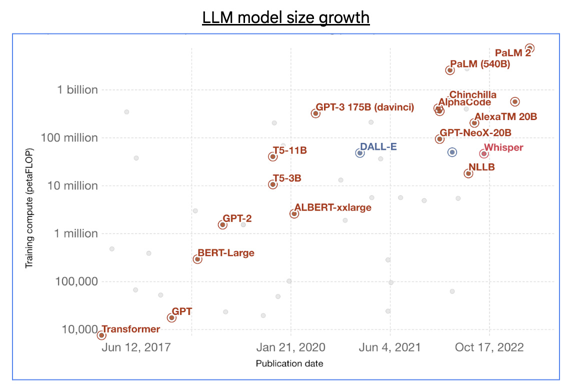

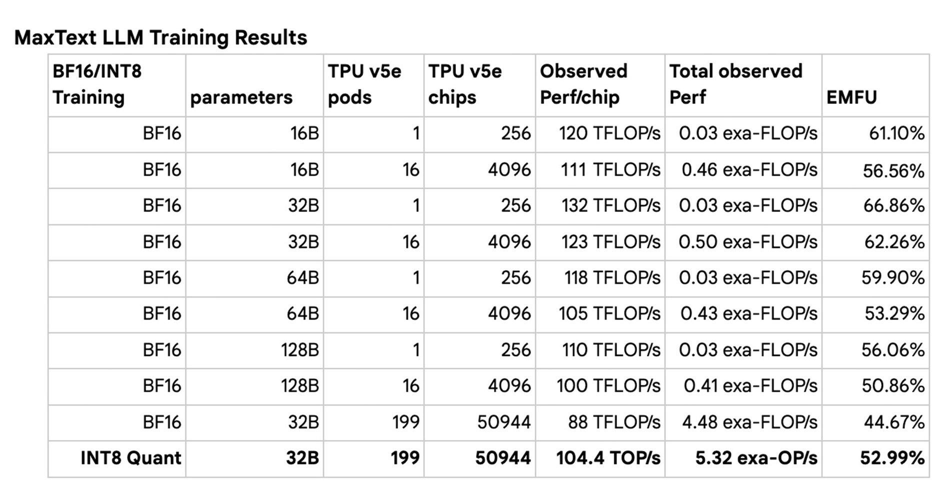



*****************************************************************************
<class 'dict'>
2


In [31]:
matched_images = get_similar_image_from_query(
    text_metadata_df,
    image_metadata_df,
    query              = query,
    column_name        = "text_embedding_from_image_description", 
    image_emb          = False,  # Use text embedding instead of image embedding
    top_n              = 2,
)

print_text_to_image_citation(matched_images, print_top=False)
print("*****************************************************************************")
display_images(
    [matched_images[0]["img_path"], matched_images[1]["img_path"]],
    #resize_ratio=0.5,
)
print("*****************************************************************************")
print(type(matched_images))
print( len(matched_images))

## Get answer with RAG

In [33]:
%%time

txt_prompt = f"""
    Answer the question and explain results with the given Images:
    Question: {query}
    Images:
"""

prompt = [
    txt_prompt,
    "Image:",       matched_images[0]["image_object"],
    "Description:", matched_images[0]["image_description"],
    "Image:",       matched_images[1]["image_object"],
    "Description:", matched_images[1]["image_description"],
]

gemini_response = get_gemini_response(
    model_15p,        # Use Gemini 1.5 Pro
    model_input       = prompt,
    safety_settings   = safety_settings,
    generation_config = GenerationConfig(temperature=1, max_output_tokens=8192),
)
rich_Markdown(gemini_response)

CPU times: user 10.4 ms, sys: 15.1 ms, total: 25.6 ms
Wall time: 3.41 s


The images provided don't contain information about "med-gemini" or any medical benchmarks. Therefore, I cannot    
answer your question based on the given images.                                                                    

The first image showcases the growth of Large Language Models (LLMs) in terms of computational power required for  
their training.                                                                                                    

The second image focuses on the training results of a specific LLM called "MaxText" using different configurations 
of hardware and data types.                                                                                        

Neither of these images provide information about "med-gemini" or any medical-related benchmarks. To answer your   
question, I need additional context or images containing information about "med-gemini" and relevant medical       
benchmark comparisons.

# Image Search
## Search similar image with image input 
- For demonstration, we will only find similar images in a single doc
- However, we can scale to match (find relevant images) across multiple docs

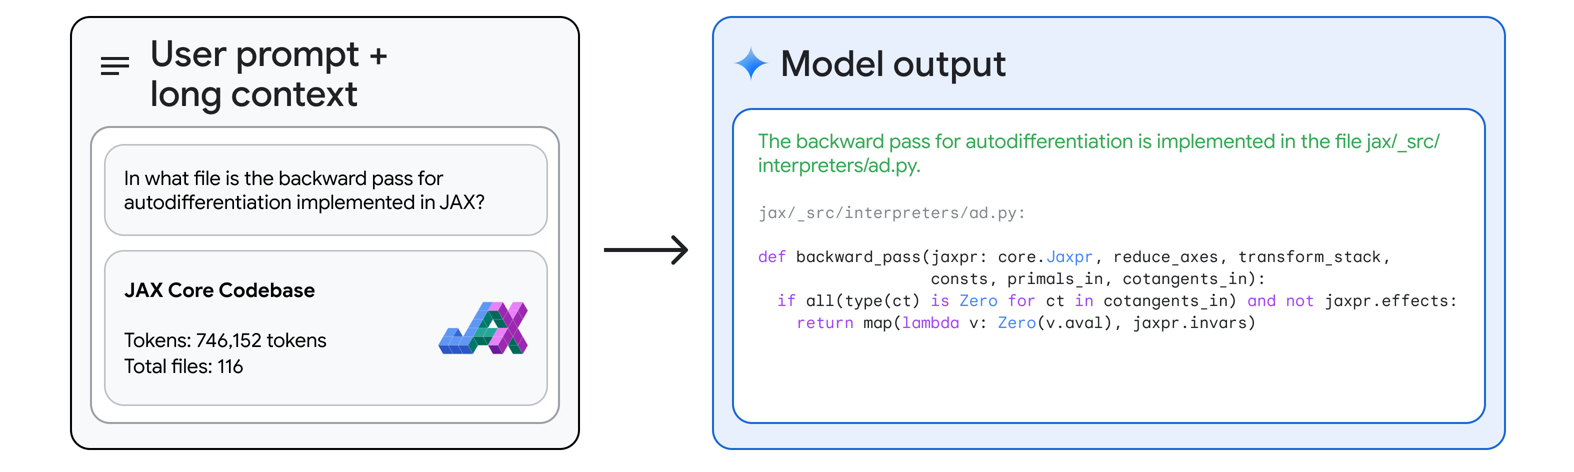

In [36]:
image_query_path = "images/gemini_v1_5_report_technical.pdf_image_4_0_142.jpeg"
display_images([image_query_path]) 

Citation 1: Matched image path, page number and page text: 

score:  0.71
file_name:  gemini_v1_5_report_technical.pdf
path:  images/gemini_v1_5_report_technical.pdf_image_4_1_143.jpeg
page number:  5
page text:  Gemini 1.5: Unlocking multimodal understanding across millions of tokens of context
4.1. Qualitative Examples of Multimodal Long-Context Capabilities
The ability to process multiple millions of tokens unlocks practical applications that were not possible
before. In this section we demonstrate some surprising interactions we observed with Gemini 1.5 Pro
across code, text and video.
As shown in the Figure 2, Gemini 1.5 Pro is able to ingest entire large codebases such as JAX
(746,152 tokens), and answer very specific queries about them. in Figure 3 we show Gemini 1.5 Pros
ability to learn a new language based only on reference materials given in its input (see Section 4.2.1.7
for quantitative metrics for this use case). Additionally, we test Gemini 1.5 Pros ability to answer
an 

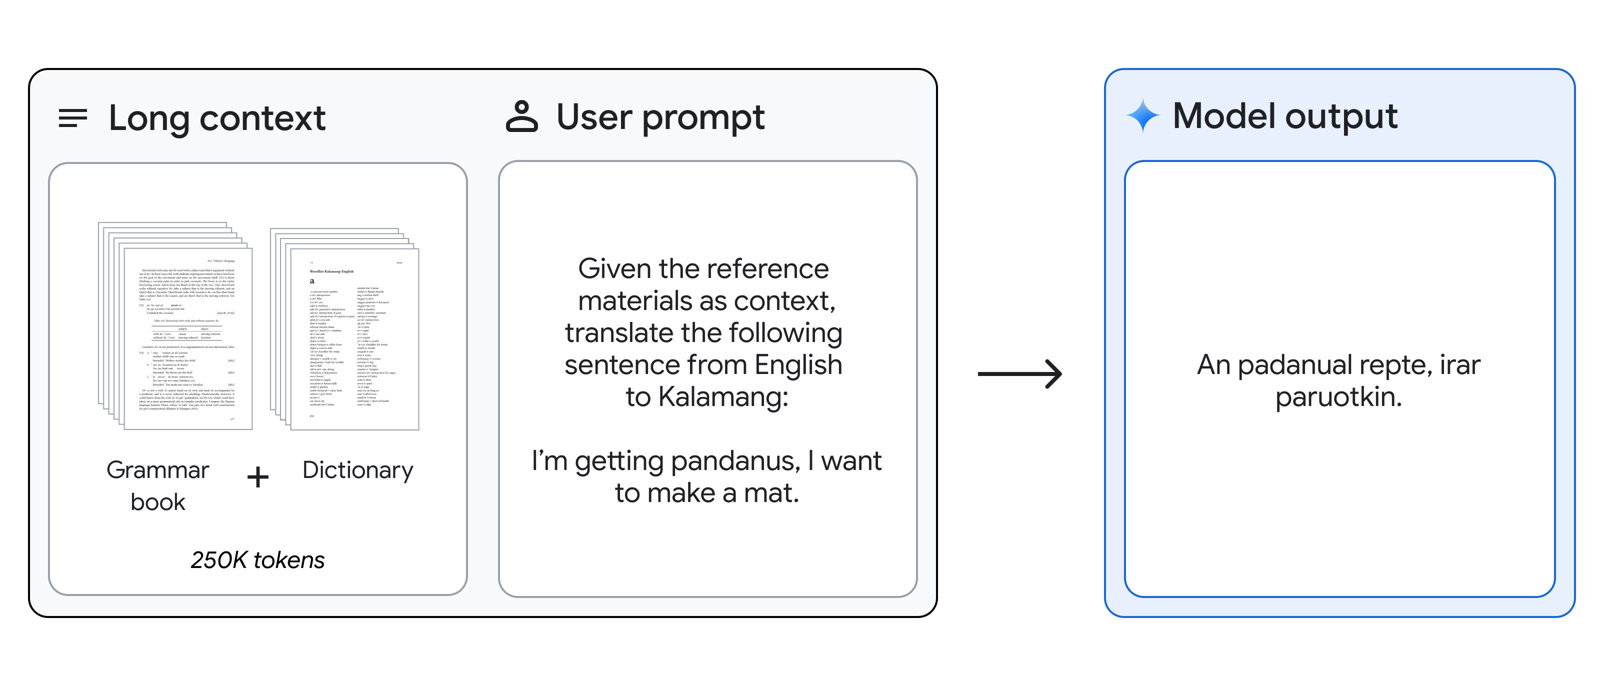

In [38]:
# Search for similar images based on input image and Image Embedding

matched_images = get_similar_image_from_query(
    text_metadata_df,
    image_metadata_df,
    query              = query,
    column_name        = "mm_embedding_from_img_only",
    image_emb          = True, #Previous: False
    image_query_path   = image_query_path, 
    embedding_size     = 1408, 
    top_n              = 2,
)
print_text_to_image_citation(matched_images, print_top=True)   
print("*****************************************************************************")
display_images([matched_images[0]["img_path"]]) 

## Another Example
In this example, we will do the following:
1) Search all the images for a specific query
2) Send those images to Gemini 1.5 Pro to ask multiple questions, where it has to compare among those images and provide answers

Citation 1: Matched image path, page number and page text: 

score:  0.76
file_name:  Google Cloud TPU blog.pdf
path:  images/Google Cloud TPU blog.pdf_image_15_0_75.jpeg
page number:  16
page text:  Scaling efficiency
We achieved excellent scaling across 50,944 TPU v5e chips, but we believe we can
improve this even further. Weve identified and are currently working on changes in the
compiler and MaxText to improve stability and performance at large scale. We are
considering scalable solutions such as hierarchical DCN collectives and further
optimizing compiler scheduling in multipod regimes.

image description:  The chart titled "TPU v5e Efficient Scaling with 32B LLM" plots the scaling factor against the number of TPU v5e chips used, ranging from 256 to 50944. Two sets of data are presented:

- "v5e Measured" is shown as blue dots and represents the actual measured scaling factor.
- "Ideal Scaling" is shown as dark blue dots and represents the theoretically expected scaling factor. 


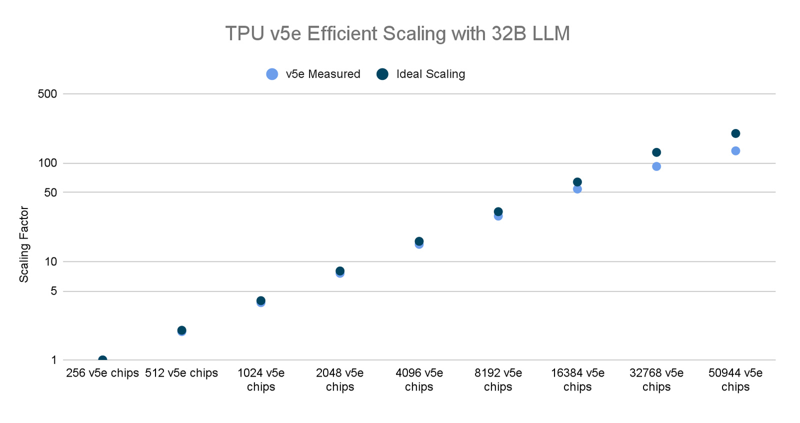

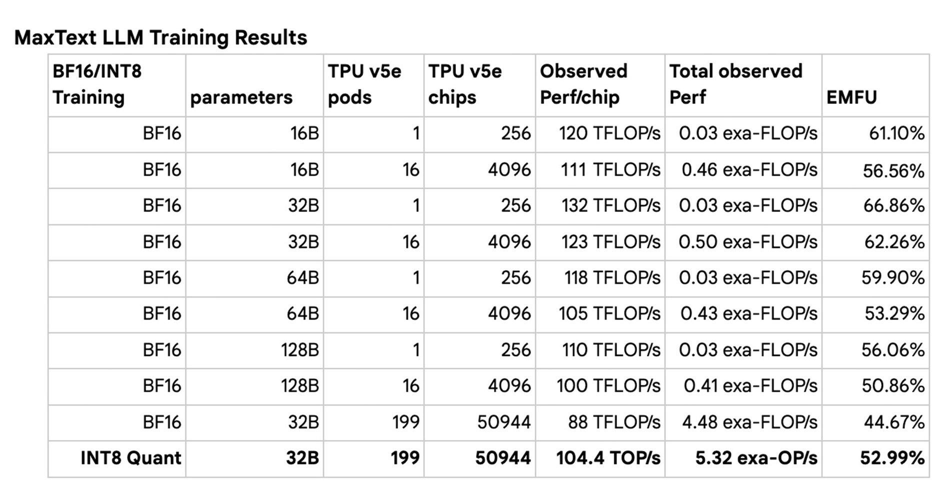

In [39]:
matched_images = get_similar_image_from_query(
    text_metadata_df,
    image_metadata_df,
    query              = "Show me all the images that can describe LLMs and TPU v5e scaling",
    column_name        = "text_embedding_from_image_description", 
    image_emb          = False,    
    top_n              = 2,
)
print_text_to_image_citation(matched_images, print_top=False)
print("*****************************************************************************")
display_images([ 
    matched_images[0]["img_path"], 
    matched_images[1]["img_path"]
])

In [42]:
%%time

query = """
 - How does the scaling efficiency of TPU v5e compare to the overall growth in LLM model size over time?
 - How does the model size impact the observed Per-chip performance and EMFU 
    for a fixed number of TPU v5e chips (e.g., 256)?
 - For the INT8 Quant training with 32B parameters, 
    how does its high EMFU relate to the observed TFLOP/chip/s?
 - How does the "per device batch (seq)" for a 16B model compare to a 128B model, 
    and how does this affect the "Total observed Perf"?
 - How might the MFU be impacted by increasing LLM model size?
 """

txt_prompt = f"""
Task: Answer the following questions in detail, 
providing clear reasoning and evidence from the images in bullet points.

Instructions:
1. Analyze the provided images focusing on the relationship between 
       a) TPU v5e scaling efficiency, 
       b) LLM model size growth, 
       c) performance metrics, and 
       d) quantization effects.
2. Answer the following questions in detail, 
       providing clear reasoning and evidence from the images in bullet points
3. Cite the image sources to support your explanations. Mention the file name.

Additional Considerations:
* Clearly define any technical terms within your answers for better understanding.
* Use specific examples and data points from the images to support your explanations.
* Feel free to request additional info or clarification if the images are unclear or ambiguous.

Question:
{query}

"""

prompt = [
    txt_prompt,
    "Images:",  matched_images[0]["image_object"], matched_images[1]["image_object"],
]

gemini_response = get_gemini_response(
    model_15p,        # Use Gemini 1.5 Pro
    model_input       = prompt,
    safety_settings   = safety_settings,
    generation_config = GenerationConfig(temperature=1, max_output_tokens=8192),
)
rich_Markdown(gemini_response)

CPU times: user 71.4 ms, sys: 25.3 ms, total: 96.6 ms
Wall time: 17.9 s


Analyzing TPU v5e Scaling and LLM Training Performance                               

Let's break down the relationship between TPU v5e efficiency, LLM model growth, performance, and quantization using
the provided images.                                                                                               

Image Sources:                                                                                                     

 • "TPU v5e Efficient Scaling with 32B LLM.png"                                                                    
 • "MaxText LLM Training Results.png"                                                                              

1. Scaling Efficiency vs. LLM Model Growth                                                                         

 • TPU v5e demonstrates increasing scaling efficiency with larger TPU pod sizes, although it remains below ideal   
   scaling.  ("TPU v5e Efficient Scaling with 32B LLM.png")                                                        
    • For instance, moving from 256 to 512 chips roughly doubles the scaling factor (from ~2x to ~4x). This trend  
      continues as the number of chips increases.                                                                  
 • The image focusing on scaling efficiency only considers a 32B parameter model. ("TPU v5e Efficient Scaling with 
   32B LLM.png")                                                                                                   
    • We lack visual data on how scaling efficiency changes with different LLM model sizes. It's possible that     
      larger models might exhibit different scaling characteristics on the TPU v5e.                                

2. Model Size Impact on Performance                                                                                

 • Larger models generally result in lower per-chip performance (TFLOP/chip/s) with a fixed TPU count. ("MaxText   
   LLM Training Results.png")                                                                                      
    • Compare the 16B model (120 TFLOP/chip/s) to the 128B model (110 TFLOP/chip/s) on 256 TPU v5e chips.          
    • This decrease likely stems from increased communication overhead and memory constraints when handling larger 
      models on a fixed hardware setup.                                                                            
 • EMFU (Effective Memory Utilization) tends to be higher for larger models on a fixed TPU count. ("MaxText LLM    
   Training Results.png")                                                                                          
    • The 128B model on 256 chips reaches 56.06% EMFU, while the 16B model achieves 61.10%.                        
    • This suggests larger models utilize the available memory bandwidth more effectively despite potential        
      communication bottlenecks.                                                                                   

3. INT8 Quantization, EMFU, and TFLOPs                                                                             

 • The 32B parameter model trained with INT8 quantization on 50944 TPU v5e chips achieves remarkably high EMFU     
   (52.99%) and impressive TFLOPs (104.4 TOP/s). ("MaxText LLM Training Results.png")                              
 • High EMFU in this case indicates that the INT8 quantization successfully reduces the memory footprint of the    
   model, allowing for better utilization of available memory bandwidth.                                           
 • This efficient memory utilization, in turn, contributes to the high TFLOP/chip/s performance, as the system     
   spends less time waiting for data movement.                                                                     

4. Per-Device Batch Size and Total Performance                                                                     

 • The image doesn't provide "per device batch (seq)" data. We need this in

# Building Multimodal QA System with mRAG

Let's bring everything together to implement multimodal RAG. We will use all the elements that we have explored in previous sections to implement the multimodal RAG. These are the steps:

1) The user gives a query in text format where the expected info is available in the docs.
2) Find all text chunks from the pages in the docs.
3) Find all similar images from the pages based on the user query.
4) Combine all similar text and images found in steps 2 and 3.
5) With the help of Gemini, we can pass the user query with text and image context. We can also add a specific instructions the model should remember while answering the user query.
6) Gemini produces the answer, and we can print the citations to check all relevant text and images used to address the query.

## Step 1: User query

In [41]:
# this time we are not passing any images, but just a simple text query.
print(query)


 - How does the scaling efficiency of TPU v5e compare to the overall growth in LLM model size over time?
 - How does the model size impact the observed Per-chip performance and EMFU 
    for a fixed number of TPU v5e chips (e.g., 256)?
 - For the INT8 Quant training with 32B parameters, 
    how does its high EMFU relate to the observed TFLOP/chip/s?
 - How does the "per device batch (seq)" for a 16B model compare to a 128B model, 
    and how does this affect the "Total observed Perf"?
 - How might the MFU be impacted by increasing LLM model size?
 


## Step 2: Get all relevant text chunks

In [44]:
matched_text = get_similar_text_from_query(
    query,
    text_metadata_df,
    column_name="text_embedding_chunk",
    top_n=20,
    chunk_text=True,
)

## Step 3: Get all relevant images

In [45]:
matched_images = get_similar_image_from_query(
    text_metadata_df,
    image_metadata_df,
    query=query,
    column_name="text_embedding_from_image_description",
    image_emb=False,
    top_n=10,
)

## Step 4: Create context_text and context_images

In [46]:
txt_prompt = """
Task: Answer the following questions in detail, 
        providing clear reasoning and evidence from the images and text in bullet points.

Instructions:
1. **Analyze:** Carefully examine the provided images and text context.
2. **Synthesize:** Integrate information from both the visual and textual elements.
3. **Reason:**  Deduce logical connections and inferences to address the questions.
4. **Respond:** Provide a concise, accurate answers in the following format:
   * **Question:** [Question]
   * **Answer:** [Direct response to the question]
   * **Explanation:** [Bullet-point reasoning steps if applicable]
   * **Source** [name of the file, page, image from where the information is citied]

5. **Ambiguity:** If the context is insufficient to answer, respond "Not enough context to answer."

"""

prompt = [
    txt_prompt,
    "Questions: ", query,
    "Image Context: ",
]
for _, value in matched_images.items():
    prompt.extend([
        "Image Path: ",        value["img_path"],
        "Image Description: ", value["image_description"],
        "Image:",              value["image_object"],
    ])

text_context = ["Text Context: "]
for key, value in matched_text.items():
    text_context.extend([
        "Text Source: ", f"""file_name: "{value["file_name"]}", Page: "{value["page_num"]}" """,
        "Text:",      value["chunk_text"],
    ])
    
prompt.extend(text_context)

## Step 5: Pass context to Gemini

In [47]:
gemini_response = get_gemini_response(
    model_15p,        # Use Gemini 1.5 Pro
    model_input       = prompt, 
    safety_settings   = safety_settings,
    generation_config = GenerationConfig(temperature=1, max_output_tokens=8192),
)
rich_Markdown(gemini_response)

 • Question: How does the scaling efficiency of TPU v5e compare to the overall growth in LLM model size over time? 
    • Answer: Not enough context to answer.                                                                        
    • Explanation: While the provided text and images discuss the scaling efficiency of TPU v5e, they do not offer 
      a direct comparison to the overall growth in LLM model size over time. "images/Google Cloud TPU              
      blog.pdf_image_1_0_10.jpeg" only visualizes the LLM model size growth, but there's no information about the  
      scaling efficiency of contemporary hardware.                                                                 
 • Question: How does the model size impact the observed Per-chip performance and EMFU for a fixed number of TPU   
   v5e chips (e.g., 256)?                                                                                          
    • Answer: For a fixed number of TPU v5e chips (256), increasing model size generally leads to lower "Observed  
      Perf/chip" but doesn't show a clear trend for EMFU.                                                          
    • Explanation:                                                                                                 
       • Observing "images/Google Cloud TPU blog.pdf_image_13_0_69.jpeg", focusing on rows with 256 chips, we can  
         see that "Observed Perf/chip" decreases as model size increases from 16B to 128B parameters.              
       • However, the EMFU values fluctuate without a clear pattern. For instance, 32B model shows a higher EMFU   
         (66.86%) than both 16B (61.10%) and 64B (59.90%) models.                                                  
    • Source: images/Google Cloud TPU blog.pdf_image_13_0_69.jpeg                                                  
 • Question: For the INT8 Quant training with 32B parameters, how does its high EMFU relate to the observed        
   TFLOP/chip/s?                                                                                                   
    • Answer: The high EMFU of 52.99% for INT8 Quant training with 32B parameters indicates that despite a lower   
      observed TFLOP/chip/s compared to its peak capability, it achieves high computational efficiency due to using
      quantized operations.                                                                                        
    • Explanation:                                                                                                 
       • EMFU is calculated as (observed TOP/chip/s) / (peak hardware TFLOP/chip/s).                               
       • INT8 quantization, while potentially reducing the raw observed TFLOP/chip/s, allows for significantly more
         operations per second (OPS) due to operating on 8-bit integers instead of 16-bit floats.                  
       • This increased OPS contributes to the high EMFU, demonstrating efficient hardware utilization despite a   
         potentially lower observed TFLOP/chip/s.                                                                  
    • Source: images/Google Cloud TPU blog.pdf_image_13_0_69.jpeg, images/Google Cloud TPU                         
      blog.pdf_image_12_0_66.jpeg, "Google Cloud TPU blog.pdf", Page: "12"                                         
 • Question: How does the "per device batch (seq)" for a 16B model compare to a 128B model, and how does this      
   affect the "Total observed Perf"?                                                                               
    • Answer: A 16B model uses a "per device batch (seq)" of 6, while a 128B model uses 1. This smaller batch size 
      for larger models is likely necessary to fit within memory constraints. The impact on "Total observed Perf"  
      cannot be definitively determined from the given information.                                                
    • Explanation:                                      

## Step 6: Print citations and references [Optional]

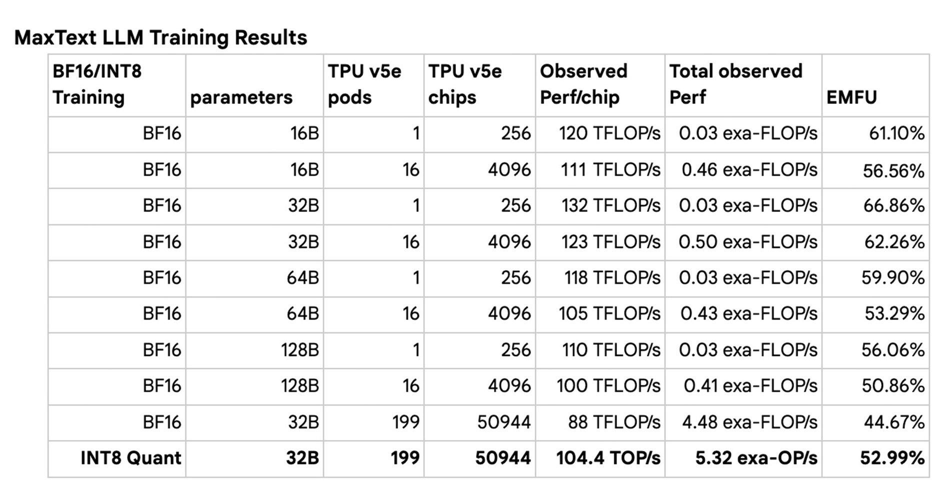

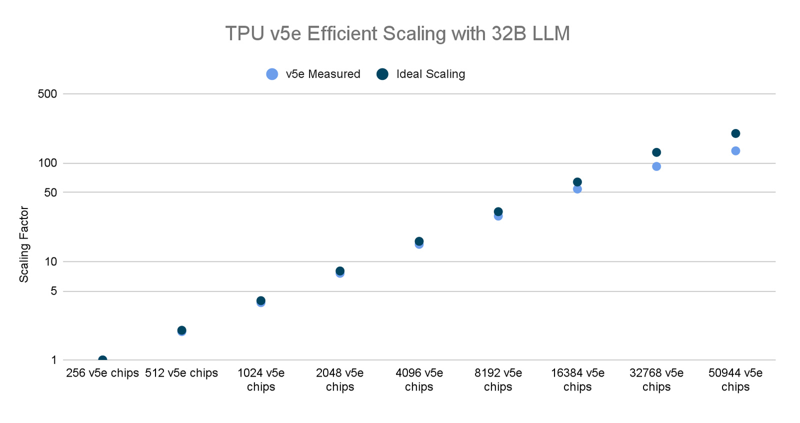

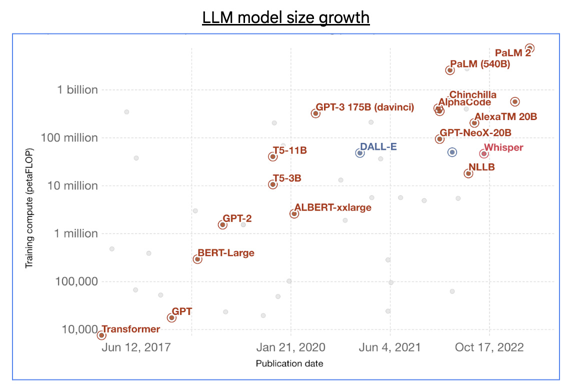

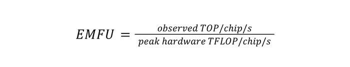

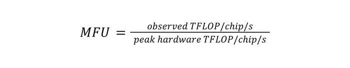

In [50]:
display_images([
    matched_images[0]["img_path"],
    matched_images[1]["img_path"],
    matched_images[2]["img_path"],
    matched_images[3]["img_path"],
    matched_images[5]["img_path"],
])

In [51]:
print_text_to_image_citation(matched_images, print_top=True)

Citation 1: Matched image path, page number and page text: 

score:  0.83
file_name:  Google Cloud TPU blog.pdf
path:  images/Google Cloud TPU blog.pdf_image_13_0_69.jpeg
page number:  14
page text:  Future work
Job start-up time

image description:  The image shows a table titled "MaxText LLM Training Results". The table presents data on training a Large Language Model (LLM) using various configurations of BF16 and INT8 data types, different numbers of parameters, TPU v5e pods and chips. It records the observed performance per chip, total observed performance, and EMFU (efficiency metric, exact meaning not visible). 

Key observations:

* Increasing the number of TPU chips generally leads to higher total observed performance but lower performance per chip.
* Using INT8 quantization significantly increases the total observed performance and achieves the highest EMFU. 



In [54]:
print_text_to_text_citation(matched_text, print_top=True)

Citation 1: Matched text: 

score:  0.79
file_name:  Google Cloud TPU blog.pdf
page_number:  13
chunk_number:  1
chunk_text:  Largest LLM distributed training job scalability results
For each model size (16B, 32B, 64B, 128B), we ran a sweep of training jobs, scaling the
number of TPU v5e pods from 1 to 160. We saw as high as 66.86% MFU with BF16
training on a single TPU v5e pod and strong scaling outcomes when expanding to 160
pods. We also ran jobs exercising the entire 199-pod cluster with both BF16 training
and INT8 quantized training (using AQT), achieving an impressive observed 5.32
exa-OP/s with INT8 quantized training. This scaling study was done with limited
software optimizations across the Multislice Training JAX stack, and we will continue
improving our software stack.



# More questions with Multimodal QA System

In [55]:
# this time we are not passing any images, but just a simple text query.

query = """
Question 1: 
Imagine a patient presents with new onset prurigo nodularis.
Could Med-Gemini-M 1.5 be used to analyze dermatological images 
  of the patient's lesions in conjunction with a comprehensive history taken
  from an EHR dialogue to help a clinician reach a diagnosis and develop a treatment plan?
What are the limitations and potential ethical considerations of using the model in this way?

Question 2: 
The paper focuses on uncertainty-guided search for text-based reasoning tasks.
How could this approach be extended to multimodal tasks?
For instance, if Med-Gemini-M 1.5 encounters uncertainty when analyzing a dermatology image, 
  could it generate queries to search for 
  relevant visual examples or supplemental clinical info to refine its interpretation?

Question 3:  
Considering the potential benefits and risks highlighted in the paper, 
  what specific steps should be taken during the development, validation, and deployment 
  of Med-Gemini models to ensure they are used safely, fairly, and effectively 
  in real-world clinical settings?
How can these steps be informed by ongoing collaboration between 
 researchers, clinicians, regulators, and patient communities?
"""

(response, matched_text, matched_images) = get_answer_from_qa_system(
    query,
    text_metadata_df,
    image_metadata_df,
    top_n_text        = 10,
    top_n_image       = 5,
    model             = model_15p,
    safety_settings   = safety_settings,
    generation_config = GenerationConfig(temperature=1, max_output_tokens=8192),
)

rich_Markdown(response)

 • Question: Imagine a patient presents with new onset prurigo nodularis. Could Med-Gemini-M 1.5 be used to analyze
   dermatological images of the patient's lesions in conjunction with a comprehensive history taken from an EHR    
   dialogue to help a clinician reach a diagnosis and develop a treatment plan? What are the limitations and       
   potential ethical considerations of using the model in this way?                                                
 • Answer: Not enough context to answer.                                                                           
 • Explanation:                                                                                                    
    • While the provided text mentions that Med-Gemini models are designed for multimodal understanding, including 
      text, code, image, video, and audio, there is no specific information about Med-Gemini-M 1.5 or its          
      capabilities in analyzing dermatological images.                                                             
    • The text primarily focuses on the model's architecture, evaluation on various benchmarks, and responsible    
      deployment approach.                                                                                         
    • Without further information on Med-Gemini-M 1.5's training data, performance on medical image analysis tasks,
      and specific safety measures for healthcare applications, it's impossible to determine its suitability for   
      diagnosing and creating treatment plans.                                                                     
 • Source:  N/A                                                                                                    
 • Question: The paper focuses on uncertainty-guided search for text-based reasoning tasks. How could this approach
   be extended to multimodal tasks? For instance, if Med-Gemini-M 1.5 encounters uncertainty when analyzing a      
   dermatology image, could it generate queries to search for relevant visual examples or supplemental clinical    
   info to refine its interpretation?                                                                              
 • Answer:  Not enough context to answer.                                                                          
 • Explanation:                                                                                                    
    • Although the question proposes an interesting application of uncertainty-guided search for multimodal tasks, 
      the provided text doesn't offer information on whether Med-Gemini models utilize this approach.              
    • The text doesn't delve into the specific search mechanisms or query generation processes employed by the     
      model.                                                                                                       
    • To adequately address whether Med-Gemini-M 1.5 can generate queries for refining its interpretations in      
      multimodal scenarios, more details on its internal workings and capabilities are required.                   
 • Source:  N/A                                                                                                    
 • Question:  Considering the potential benefits and risks highlighted in the paper, what specific steps should be 
   taken during the development, validation, and deployment of Med-Gemini models to ensure they are used safely,   
   fairly, and effectively in real-world clinical settings? How can these steps be informed by ongoing             
   collaboration between researchers, clinicians, regulators, and patient communities?                             
 • Answer: The provided text emphasizes a structured approach to responsible deployment for Med-Gemini models. To  
   ensure safe, fair, and effective use in real-world clinical settings, specific steps should be taken during     
   development, validation, and deployment, informed by 

In [56]:
query = """
Question 1: 
How does the mixture-of-experts architecture in Gemini 1.5 Pro contribute to 
  its ability to handle long context while maintaining performance on core capabilities? 
Discuss the potential trade-offs involved.

Question 2: 
Gemini 1.5 Pro incorporates various safety mitigations, 
  including supervised fine-tuning and reinforcement learning.
Discuss the effectiveness of these mitigations 
  in addressing content safety and representational harms in both text-to-text and
image-to-text modalities. How can these evaluations be improved?

Question 3: 
Gemini 1.5 Pro demonstrates surprising in-context language learning capabilities for Kalamang,
  a low-resource language. 
What are the implications of this finding for language preservation and revitalization?
What challenges need to be addressed for broader applicability of this approach?
"""

(response, matched_text, matched_images) = get_answer_from_qa_system(
    query,
    text_metadata_df,
    image_metadata_df,
    top_n_text        = 10,
    top_n_image       = 5,
    model             = model_15p,
    safety_settings   = safety_settings,
    generation_config = GenerationConfig(temperature=1, max_output_tokens=8192),
)

rich_Markdown(response)

Gemini 1.5 Pro Analysis                                              

Question 1: How does the mixture-of-experts architecture in Gemini 1.5 Pro contribute to its ability to handle long
context while maintaining performance on core capabilities? Discuss the potential trade-offs involved.             

Answer:  While the provided text highlights Gemini 1.5 Pro's ability to handle long contexts and maintain          
performance on core tasks, it doesn't explicitly explain how the mixture-of-experts (MoE) architecture contributes 
to these achievements.                                                                                             

Explanation:                                                                                                       

 • The text mentions that Gemini 1.5 Pro utilizes a MoE architecture and that this architecture allows for handling
   long contexts.                                                                                                  
 • However, there's no explanation of how MoE specifically enables this improved long context handling.            
 • The text also states that this improvement doesn't sacrifice performance on core capabilities but doesn't detail
   why.                                                                                                            

Source:  "gemini_v1_5_report_technical.pdf" Pages: "1", "3", "30"                                                  

Therefore, based on the provided text, we cannot definitively explain the connection between MoE architecture and  
long context handling or its impact on core capabilities.                                                          

Potential Trade-offs (General MoE Knowledge):                                                                      

 • Increased Complexity: MoE models are more complex to train and deploy compared to standard Transformer models.  
 • Computational Overhead: Routing mechanisms in MoE, while enabling selective expert usage, can increase          
   computational cost.                                                                                             

Question 2: Gemini 1.5 Pro incorporates various safety mitigations, including supervised fine-tuning and           
reinforcement learning. Discuss the effectiveness of these mitigations in addressing content safety and            
representational harms in both text-to-text and image-to-text modalities. How can these evaluations be improved?   

Answer:  Not enough context to answer.                                                                             

Explanation:                                                                                                       

 • The text mentions the use of supervised fine-tuning and reinforcement learning for safety mitigations.          
 • However, it doesn't provide specific details about how these techniques are applied or their effectiveness in   
   addressing content safety and representational harms.                                                           
 • Additionally, there's no information about the evaluation of these mitigations in either text-to-text or        
   image-to-text modalities.                                                                                       

Source:  Not applicable                                                                                            

Question 3: Gemini 1.5 Pro demonstrates surprising in-context language learning capabilities for Kalamang, a       
low-resource language. What are the implications of this finding for language preservation and revitalization? What
challenges need to be addressed for broader applicability of this approach?                                        

Answer: Gemini 1.5 Pro's ability to translate Kalamang using only in-context learning with a grammar manual,       
dictionary, and parallel sentences presents promising implications for language preserv